# MNIST solved at > 95% with numpy.
# I started from math on paper so a lot of stuff is inefficient.

In [2]:
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib.pyplot import plot
from matplotlib.pyplot import show

# Let's define useful stuff & check it.

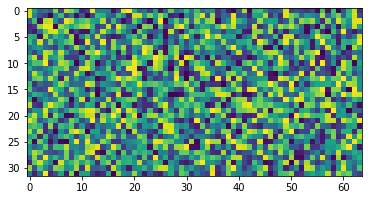

In [35]:
#random matrix for weights & biases;
def m(m, n):
    matrix = np.random.uniform(-0.1, 0.1, size=(m,n))
    return matrix / np.sqrt(m*n)
imshow(m(32, 64))

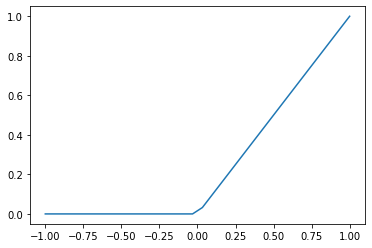

In [4]:
#layer 1 activation;
relu = lambda x: np.maximum(x, 0.)
plot(np.linspace(-1, 1, 32), relu(np.linspace(-1, 1, 32)))

In [5]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

#layer 2 activation
def matrix_softmax(m):
    return np.apply_along_axis(softmax, 0, m)

In [6]:
x = m(2, 3)
print(x)

#notice how each column adds up to 1, as probabilities should;
print(matrix_softmax(x))

[[-0.0230341  -0.35183046  0.38423017]
 [ 0.2204718  -0.04562886 -0.34328501]]
[[0.43942256 0.42404216 0.67425976]
 [0.56057744 0.57595784 0.32574024]]


In [7]:
#gets data for training & testing;
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

In [8]:
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

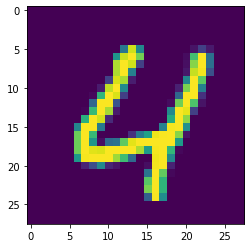

In [9]:
imshow(X_train[64])

In [10]:
#encodes lables from 1 to [0, 1, 0, 0..] as prob. distr.;
#so it could be compared to predicted prob. distr.;
def row(n):
    return [1 if i == n else 0 for i in range(10)]

#picks a batch of train inputs of size bs and number i;
#used in training loop;
def get_x(x, bs, i):
    return x[bs*i : bs*(i+1)]

#picks a batch of train outputs;
def get_y(y, bs, i):
    return y[bs*i : bs*(i+1)].T

In [11]:
#prepare data for training;
y = np.array([row(n) for n in Y_train])
x = np.array([m.reshape(-1, 1) for m in X_train])
x = x / 255 

# A forward pass.

In [12]:
#random parameters;
W0 = m(128, 784)
b0 = m(128, 1)
W1 = m(10, 128)
b1 = m(10, 1)

#input batch;
x0 = get_x(x, 2, 1).T

#hidden layer;
x1 = W0 @ x0 + b0
l1 = relu(x1)

#l2 is output;
x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2[0])
l2

array([[0.13563098, 0.13593062],
       [0.08263909, 0.0825377 ],
       [0.11331665, 0.11390953],
       [0.10253514, 0.10246403],
       [0.07700826, 0.07705405],
       [0.10112855, 0.10073138],
       [0.07632828, 0.07620509],
       [0.11329556, 0.11347252],
       [0.10801991, 0.10794026],
       [0.09009759, 0.08975481]])

# A backward pass.

In [13]:
#"jacobians" for computing 4 useful gradients;
dloss_dx2 = (l2 - get_y(y, 2, 1)).T
dx2_dl1 = W1
dx1_dW0 = x0[0]
dx2_dW1 = (l1[0].T)

#chain rule; currently it's ugly;
#these 4 will be used in SGD;
#but like any enterprise, when under a new management, 
#there's always a slight duplication of efforts;
dloss_dW0 = ((dloss_dx2 @ dx2_dl1) * ((l1[0]>0) + 0.).T ).T @ dx1_dW0.T
dloss_dW1 = dloss_dx2.T @ dx2_dW1
dloss_db0 = ((dloss_dx2 @ dx2_dl1 * (l1[0]>0).T  )).sum(axis=0).reshape(-1,1)
dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)

In [106]:
#calculates gradients on a batch with given parameters;
#will be used in gradient descent;
def grads(train, labels, W0, W1, b0, b1):

    x0 = train
    x1 = W0 @ x0 + b0
    l1 = relu(x1)
    x2 = W1 @ l1 + b1
    l2 = matrix_softmax(x2[0])

    dloss_dx2 = (l2 - labels).T
    dx2_dl1 = W1
    dx1_dW0 = x0[0]
    dx2_dW1 = (l1[0].T)
 
    dloss_dW0 = ((dloss_dx2 @ dx2_dl1) * ((l1[0]>0) + 0.).T ).T @ dx1_dW0.T
    dloss_dW1 = dloss_dx2.T @ dx2_dW1
    dloss_db0 = ((dloss_dx2 @ dx2_dl1 * (l1[0]>0).T  )).sum(axis=0).reshape(-1,1)
    dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)
    
    return (dloss_dW0, dloss_dW1, dloss_db0, dloss_db1)

# Training.

In [387]:
60000/256

234.375

In [111]:
#4096 is way too much but I wanted > 95% accuracy
#for like no reason

W0 = m(64, 784)
b0 = m(64, 1)
W1 = m(10, 64)
b1 = m(10, 1)

#training loop with batch size 256 and learning rate 0.0045
#230 epoches
lr = 0.0045
for i in range(230):

    x_train = get_x(x, 256, i).T
    y_train = get_y(y, 256, i)
    
    #how sensitive is loss to small changes in parameters?
    dloss_dW0, dloss_dW1, dloss_db0, dloss_db1 = grads(x_train, y_train, W0, W1, b0, b1)
    
    #minimising loss by nudging parameters;
    W0 = W0 - dloss_dW0 * lr
    W1 = W1 - dloss_dW1 * lr
    b0 = b0 - dloss_db0 * lr
    b1 = b1 - dloss_db1 * lr
    #getting better parameters as a result;
    
mistakes = sum([(predict(xt[i]) - np.argmax(yt[i]) != 0) + 0. for i in range(10000)])
(10000 - mistakes) / 10000

0.8902

# Testing.

In [17]:
#preparing test data
yt = np.array([row(n) for n in Y_test])
xt = X_test
xt = xt / 255 

In [38]:
def predict(img):
    x0 = img.reshape(-1,1)
    x1 = W0 @ x0 + b0
    l1 = relu(x1)
    x2 = W1 @ l1 + b1
    l2 = softmax(x2)
    #print(x2)
    return np.argmax(l2)

In [72]:
x0 = X_test[0].reshape(-1,1)
x1 = W0 @ x0 + b0
l1 = relu(x1)
x2 = (W1 @ l1 + b1) / 10000
l2 = softmax(x2)
print(np.round(l2, 2))

[[0.1 ]
 [0.09]
 [0.11]
 [0.11]
 [0.08]
 [0.1 ]
 [0.08]
 [0.14]
 [0.09]
 [0.1 ]]


In [38]:
[np.argmax(yt[i]) for i in range(10000) if(predict(xt[i]) - np.argmax(yt[i])) ]

[4,
 5,
 9,
 6,
 5,
 9,
 9,
 4,
 2,
 5,
 5,
 6,
 5,
 8,
 9,
 3,
 4,
 6,
 9,
 2,
 9,
 7,
 9,
 7,
 9,
 9,
 7,
 5,
 4,
 2,
 9,
 5,
 5,
 5,
 5,
 4,
 2,
 7,
 5,
 8,
 9,
 5,
 3,
 5,
 5,
 3,
 6,
 5,
 5,
 8,
 5,
 9,
 7,
 2,
 3,
 4,
 5,
 8,
 6,
 5,
 9,
 8,
 9,
 7,
 5,
 9,
 5,
 8,
 8,
 4,
 4,
 9,
 5,
 2,
 5,
 9,
 2,
 2,
 5,
 9,
 8,
 5,
 6,
 3,
 5,
 5,
 2,
 2,
 5,
 4,
 3,
 9,
 5,
 5,
 8,
 5,
 7,
 5,
 9,
 2,
 5,
 0,
 2,
 6,
 9,
 3,
 2,
 9,
 2,
 6,
 5,
 3,
 7,
 5,
 9,
 5,
 8,
 9,
 5,
 8,
 4,
 9,
 5,
 5,
 4,
 6,
 4,
 8,
 1,
 8,
 9,
 3,
 2,
 5,
 8,
 7,
 7,
 0,
 8,
 9,
 4,
 3,
 8,
 5,
 4,
 8,
 9,
 9,
 5,
 8,
 4,
 2,
 3,
 5,
 1,
 2,
 9,
 3,
 2,
 9,
 9,
 5,
 5,
 2,
 5,
 2,
 0,
 7,
 9,
 9,
 5,
 9,
 7,
 7,
 8,
 5,
 5,
 4,
 5,
 8,
 0,
 5,
 2,
 2,
 5,
 4,
 2,
 2,
 5,
 4,
 4,
 5,
 8,
 5,
 5,
 5,
 8,
 5,
 9,
 2,
 4,
 9,
 2,
 8,
 8,
 5,
 5,
 9,
 8,
 8,
 4,
 9,
 9,
 3,
 7,
 8,
 4,
 9,
 8,
 2,
 9,
 7,
 4,
 5,
 2,
 6,
 3,
 8,
 7,
 5,
 5,
 1,
 4,
 7,
 6,
 9,
 5,
 3,
 3,
 8,
 9,
 9,
 5,
 7,
 6,
 4,
 5,
 4,
 5,
 9,


In [38]:
from PIL import Image
a = np.array(Image.open("kek.png")).T[-1].T

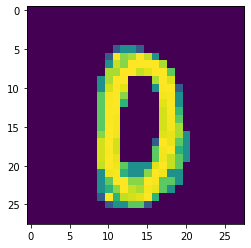

In [39]:
imshow(a)

In [40]:
predict(a)

0

Help on function save in module numpy:

save(file, arr, allow_pickle=True, fix_imports=True)
    Save an array to a binary file in NumPy ``.npy`` format.
    
    Parameters
    ----------
    file : file, str, or pathlib.Path
        File or filename to which the data is saved.  If file is a file-object,
        then the filename is unchanged.  If file is a string or Path, a ``.npy``
        extension will be appended to the filename if it does not already
        have one.
    arr : array_like
        Array data to be saved.
    allow_pickle : bool, optional
        Allow saving object arrays using Python pickles. Reasons for disallowing
        pickles include security (loading pickled data can execute arbitrary
        code) and portability (pickled objects may not be loadable on different
        Python installations, for example if the stored objects require libraries
        that are not available, and not all pickled data is compatible between
        Python 2 and Python 3).
  

In [112]:
np.save("W0", W0) 
np.save("b0", b0)
np.save("W1", W1) 
np.save("b1", b1)

In [44]:
WW0 = np.load("W0.npy")

In [69]:
predict(X_test[4])

1

In [ ]:
7 9  12 16

In [79]:
import math

@np.vectorize
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

@np.vectorize
def der_sig(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [77]:
#will be used in gradient descent;
def grads(train, labels, W0, W1, b0, b1):

    x0 = train
    x1 = W0 @ x0 + b0
    l1 = sigmoid(x1)
    x2 = W1 @ l1 + b1
    l2 = matrix_softmax(x2[0])

    dloss_dx2 = (l2 - labels).T
    dx2_dl1 = W1
    dx1_dW0 = x0[0]
    dx2_dW1 = (l1[0].T)
 
    dloss_dW0 = ((dloss_dx2 @ dx2_dl1) * (der_sig(l1[0])).T ).T @ dx1_dW0.T
    dloss_dW1 = dloss_dx2.T @ dx2_dW1
    dloss_db0 = ((dloss_dx2 @ dx2_dl1 * (der_sig(l1[0])).T  )).sum(axis=0).reshape(-1,1)
    dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)
    
    return (dloss_dW0, dloss_dW1, dloss_db0, dloss_db1)

In [86]:
W0 = m(128, 784)
b0 = m(128, 1)
W1 = m(10, 128)
b1 = m(10, 1)

#training loop with batch size 256 and learning rate 0.0045
#230 epoches
lr = 0.001
for i in range(230):

    x_train = get_x(x, 256, i).T
    y_train = get_y(y, 256, i)
    
    #how sensitive is loss to small changes in parameters?
    dloss_dW0, dloss_dW1, dloss_db0, dloss_db1 = grads(x_train, y_train, W0, W1, b0, b1)
    
    #minimising loss by nudging parameters;
    W0 = W0 - dloss_dW0 * lr
    W1 = W1 - dloss_dW1 * lr
    b0 = b0 - dloss_db0 * lr
    b1 = b1 - dloss_db1 * lr
    #getting better parameters as a result;
    
mistakes = sum([(predict(xt[i]) - np.argmax(yt[i]) != 0) + 0. for i in range(1000)])
(1000 - mistakes) / 1000

0.696

In [99]:
x0 = X_train[2].reshape(-1,1)
x1 = W0 @ x0 + b0
l1 = sigmoid(x1)
x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2)

In [102]:
np.round(l2, 2)

array([[0.01],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.71],
       [0.02],
       [0.05],
       [0.  ],
       [0.02],
       [0.18]])

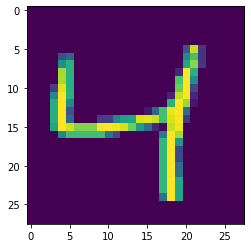

In [104]:
imshow(X_train[2])